In [1]:
%load_ext autoreload
%autoreload 1
%aimport RedditProcessing

In [2]:
import string
import json
import codecs
import re

import pandas as pd
import nltk
from nltk.tokenize import TweetTokenizer
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')

from colorama import Fore, Back, Style
import pandas as pd
import matplotlib.pyplot as plt

from textblob import TextBlob
from wordcloud import WordCloud, STOPWORDS

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Natalie\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [3]:
# load json file
fJsonName_reddit = 'olympics_posts_reddit.json'
fJsonName_youtube = 'youtube_olympics_data_limited_250_per_hashtag.json'
# Flag to determine whether to print out tweets and their sentiment
flagPrint = False

# Define tweet tokenizer
tweetTokenizer = TweetTokenizer()
lPunct = list(string.punctuation)
# Define the stopwords
lStopwords = stopwords.words('english') + lPunct + ['rt', 'via', '...', '…', '"', "'", '`']

# Call the RedditProcessing python script
redditProcessor = RedditProcessing.RedditProcessing(tweetTokenizer, lStopwords)

In [4]:
import pandas as pd
# import json file 
with open(fJsonName_reddit, 'r') as f:
    dSubmissions = json.load(f)

olympics_post = []
for sub in dSubmissions:
    olympics_post.append({'title': sub['title'],
            'author': sub['author_id'],
            'text' : sub['selftext'],
            'created': sub['created'],
            'olympics':sub['keyword'],
            'type' : "post",
            })

olympics_comment_reddit = []
for sub in dSubmissions:
    for com in sub['comments']:
        olympics_comment_reddit.append({
            'title': sub['title'],
            'author':com['author_id'],
            'text':com['body'],
            'created':com['created'],
            'olympics':sub['keyword'],
            'type':"comment"
        })

reddit_df = pd.DataFrame(olympics_post)
reddit_com_df = pd.DataFrame(olympics_comment_reddit)

In [5]:
with open(fJsonName_youtube, 'r') as f:
    ySubmissions = json.load(f)

olympics_post2 = []
for sub in ySubmissions:
    olympics_post2.append({'title': sub['Video Title'],
            'text' : sub['Description'],
            'olympics':sub['Hashtag'],
            'created':sub['Publish Time']
            })
    
olympics_comment_youtube  = []
for sub in ySubmissions:
    for com in sub['Comments']:
        olympics_comment_youtube.append({
            'title':sub['Video Title'],
            'author':com['author'],
            'text':com['text'],
            'created':com['published_at'],
            'olympics':sub['Hashtag']
        })

youtube_df = pd.DataFrame(olympics_post2)
youtube_com_df = pd.DataFrame(olympics_comment_youtube) 

In [6]:
reddit_2024 = reddit_df[reddit_df['olympics'] == 'Olympics 2024']
reddit_2020 = reddit_df[reddit_df['olympics'] == 'Olympics 2020']
reddit_2016 = reddit_df[reddit_df['olympics'] == 'Olympics 2016']

reddit_com_2024 = reddit_com_df[reddit_com_df['olympics'] == 'Olympics 2024']
reddit_com_2020 = reddit_com_df[reddit_com_df['olympics'] == 'Olympics 2020']
reddit_com_2016 = reddit_com_df[reddit_com_df['olympics'] == 'Olympics 2016']

In [7]:
youtube_2024 = youtube_df[youtube_df['olympics'] == '#paris2024']
youtube_2020 = youtube_df[youtube_df['olympics'] == '#tokyo2024']
youtube_2016 = youtube_df[youtube_df['olympics'] == '#rio2016']

youtube_com_2024 = youtube_com_df[youtube_com_df['olympics'] == '#paris2024']
youtube_com_2020 = youtube_com_df[youtube_com_df['olympics'] == '#tokyo2024']
youtube_com_2016 = youtube_com_df[youtube_com_df['olympics'] == '#rio2016']

## Approach 2: Vader based approach to sentiment analysis

In [9]:
def vaderPrintTokens(lTokens, dSentimentScores):
    """
    Print out the tokens and sentiment score.
    
    @param lTokens: List of tokens to print and colour.
    @dSentimentScores: Dictionary of sentiment from Vader.

    """
    print(*lTokens, sep=', ')
    for cat,score in dSentimentScores.items():
        print('{0}: {1}, '.format(cat, score), end='')
    print()

In [10]:
def processAndAnalyzeSentiment(reddit_df, reddit_com_df, youtube_df, youtube_com_df, bPrint, tweetProcessor):
    """
    Process and analyze sentiment for both Reddit and YouTube data using VADER.

    Args:
    reddit_df (DataFrame): DataFrame containing Reddit post data.
    reddit_com_df (DataFrame): DataFrame containing Reddit comment data.
    youtube_df (DataFrame): DataFrame containing YouTube post data.
    youtube_com_df (DataFrame): DataFrame containing YouTube comment data.
    bPrint (bool): Whether to print sentiment tokens with highlighting.
    tweetProcessor (object): TweetProcessing object, used to pre-process each post.

    Returns:
    lSentiment (list): A list of lists, where each sublist contains [date, olympics_keyword, sentiment].
    """
    
    # Define the vader sentiment analyzer
    sentAnalyser = SentimentIntensityAnalyzer()
    
    # List to store processed posts and sentiment scores
    lSentiment = []
    
    # Process 'reddit' and 'youtube'
    for s in ['reddit', 'youtube']:
        if s == 'reddit':
            # Process Reddit posts
            for row in reddit_df.itertuples(index=True, name='RedditRow'):
                submissionsTitle = row.title
                submissionSelftext = row.text
                postDate = row.created
                olympicsKeyword = row.olympics
                
                # Tokenize, filter stopwords, and convert to lowercase
                lTokens = tweetProcessor.process(submissionsTitle + ' ' + submissionSelftext)
                
                # Compute sentiment scores
                dSentimentScores = sentAnalyser.polarity_scores(" ".join(lTokens))
                
                # Save the date and sentiment of each post
                lSentiment.append([pd.to_datetime(postDate, unit='s').strftime('%Y-%m-%d %H:%M:%S'), olympicsKeyword, dSentimentScores['compound']])
                
                # Print sentiments by color
                if bPrint:
                    vaderPrintTokens(lTokens, dSentimentScores)

            # Process Reddit comments
            for comment_row in reddit_com_df.itertuples(index=True, name='RedditCommentRow'):
                commentText = comment_row.text
                postDate = comment_row.created
                olympicsKeyword = comment_row.olympics
                
                # Tokenize, filter stopwords, and convert to lowercase
                lTokens = tweetProcessor.process(commentText)
                
                # Compute sentiment scores
                dSentimentScores = sentAnalyser.polarity_scores(" ".join(lTokens))
                
                # Save the date and sentiment of each comment
                lSentiment.append([pd.to_datetime(postDate, unit='s').strftime('%Y-%m-%d %H:%M:%S'), olympicsKeyword, dSentimentScores['compound']])
                
                # Print sentiments by color
                if bPrint:
                    vaderPrintTokens(lTokens, dSentimentScores)
                
        else:  # Process YouTube
            # Process YouTube posts
            for row in youtube_df.itertuples(index=True, name='YouTubeRow'):
                submissionsTitle = row.title
                submissionDescription = row.text
                postDate = row.created
                olympicsKeyword = row.olympics
                
                # Tokenize, filter stopwords, and convert to lowercase
                lTokens = tweetProcessor.process(submissionsTitle + ' ' + submissionDescription)
                
                # Compute sentiment scores
                dSentimentScores = sentAnalyser.polarity_scores(" ".join(lTokens))
                
                # Save the date and sentiment of each post
                lSentiment.append([pd.to_datetime(postDate).strftime('%Y-%m-%d %H:%M:%S'), olympicsKeyword, dSentimentScores['compound']])
                
                # Print sentiments by color
                if bPrint:
                    vaderPrintTokens(lTokens, dSentimentScores)

            # Process YouTube comments
            for comment_row in youtube_com_df.itertuples(index=True, name='YouTubeCommentRow'):
                commentText = comment_row.text
                postDate = comment_row.created
                olympicsKeyword = comment_row.olympics
                
                # Tokenize, filter stopwords, and convert to lowercase
                lTokens = tweetProcessor.process(commentText)
                
                # Compute sentiment scores
                dSentimentScores = sentAnalyser.polarity_scores(" ".join(lTokens))
                
                # Save the date and sentiment of each comment
                lSentiment.append([pd.to_datetime(postDate).strftime('%Y-%m-%d %H:%M:%S'), olympicsKeyword, dSentimentScores['compound']])
                
                # Print sentiments by color
                if bPrint:
                    vaderPrintTokens(lTokens, dSentimentScores)
    
    return lSentiment


In [11]:
# Compute the sentiment for 2024
lSentiment_2024 = []
lSentiment_2024 = processAndAnalyzeSentiment(reddit_2024, reddit_com_2024, youtube_2024, youtube_com_2024, flagPrint, redditProcessor)

# Compute the sentiment for 2020
lSentiment_2020 = []
lSentiment_2020 = processAndAnalyzeSentiment(reddit_2020, reddit_com_2020, youtube_2020, youtube_com_2020, flagPrint, redditProcessor)

# Compute the sentiment for 2016
lSentiment_2016 = []
lSentiment_2016 = processAndAnalyzeSentiment(reddit_2016, reddit_com_2016, youtube_2016, youtube_com_2016, flagPrint, redditProcessor)


## Time Series Plot for Each Olympics

In [13]:
def plotOlympicsSentimentTimeSeries(sentiment_datasets, years, date_ranges):
    """
    Creates time series plots for each Olympics event by year in subplots,
    filtering the data with different date ranges for each event.

    Args:
    sentiment_datasets (list of lists): List containing sentiment data for each year.
    years (list): List of years or keywords (e.g., 'Olympics 2024').
    date_ranges (list): List of (start_date, end_date) tuples for each event.
    """
    
    # Create a figure with subplots based on the number of years
    num_years = len(years)
    fig, axes = plt.subplots(1, num_years, figsize=(6 * num_years, 6))
    
    for ax, sentiment_data, year, (start_date, end_date) in zip(axes, sentiment_datasets, years, date_ranges):
        # Convert the sentiment data to a DataFrame
        series = pd.DataFrame(sentiment_data, columns=['date', 'keyword', 'sentiment'])
        
        # Ensure the 'date' column is in datetime format
        series['date'] = pd.to_datetime(series['date'], utc=True)
        
        # Filter the data for the specific year and date range
        filtered_series = series[(series['date'] >= start_date) &
                                 (series['date'] <= end_date)]
        
        # Drop the specified column and set 'date' as the index
        filtered_series = filtered_series.drop('keyword', axis=1)
        filtered_series.set_index('date', inplace=True)

        # Convert 'sentiment' column to numeric and resample data by day
        filtered_series[['sentiment']] = filtered_series[['sentiment']].apply(pd.to_numeric)
        newSeries = filtered_series.resample('1D').sum()

        # Plot the time series for the current event (year)
        ax.plot(newSeries.index, newSeries['sentiment'], label='Sentiment Score')
        ax.tick_params(axis='x', rotation=90)        
        ax.set_title(f'Time Series for Olympics {year}')
        ax.set_ylabel('Sentiment Score')
        ax.set_xlabel('Date')
        ax.legend()

    # Adjust layout to ensure everything fits well
    plt.tight_layout()

    # Show the combined plot with subplots
    plt.show()

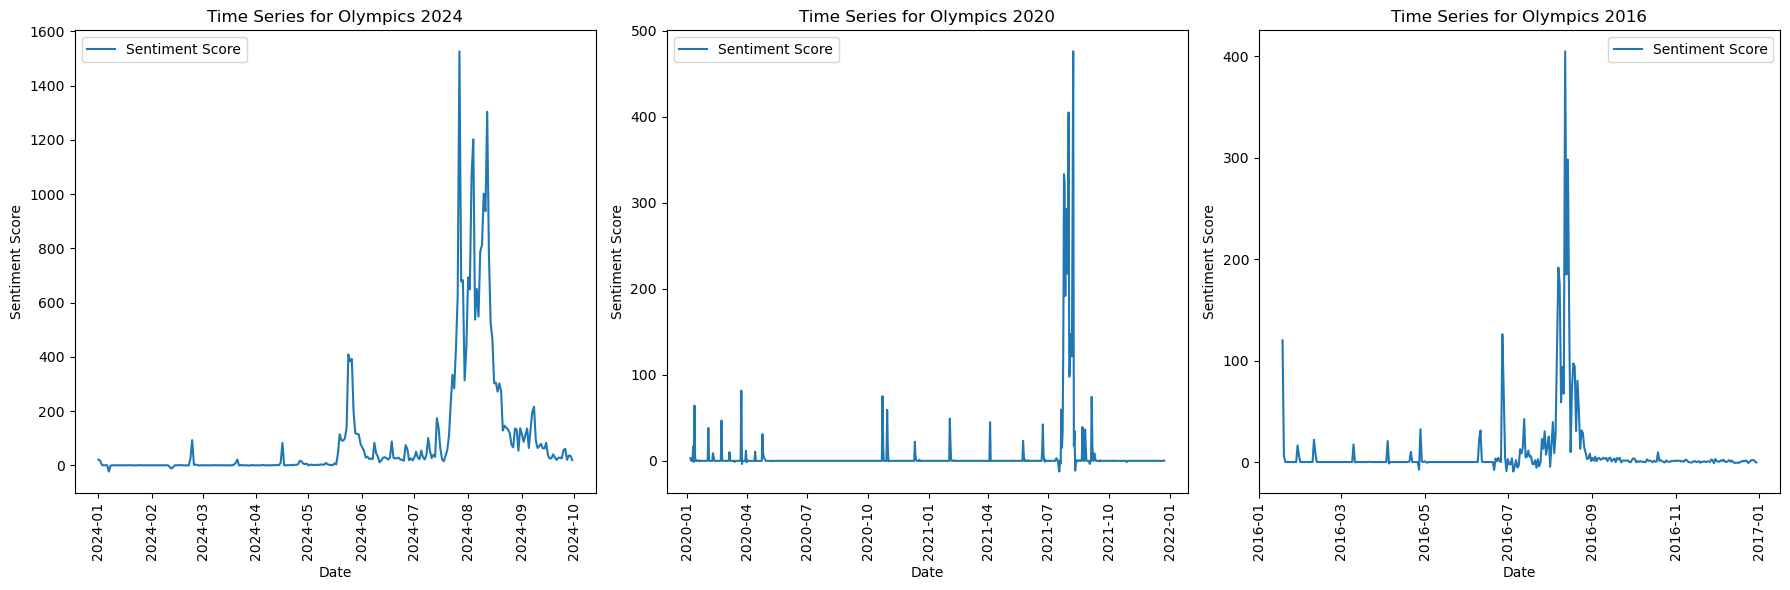

In [14]:
sentiment_datasets = [lSentiment_2024, lSentiment_2020, lSentiment_2016]
years = ['2024', '2020', '2016']
date_ranges = [('2024-01-01', '2024-10-01'),  # Date range for 'Olympics 2024'
               ('2020-01-01', '2022-01-01'),  # Date range for 'Olympics 2020'
               ('2016-01-01', '2016-12-31')]  # Date range for 'Olympics 2016'
plotOlympicsSentimentTimeSeries(sentiment_datasets, years, date_ranges)

## Word Clouds for Each Olympics

In [16]:
# Create a function to print a word cloud for positive, neutral and negative sentiments
def printWordCloud(x, category):
    cat_reddit = " ".join([word for word in x[x["sentiment_category"] == category]["title"]])

    wc = WordCloud(background_color="white", max_words=50, stopwords=STOPWORDS, random_state = 999)

    # Generate and plot wordcloud
    plt.figure(figsize=(16, 10))
    plt.imshow(wc.generate(cat_reddit))
    plt.title(f'{category} Sentiment Words', fontsize=20)
    plt.axis("off")
    plt.show()

# Define the function to categorize sentiment values
def categorize_sentiment(value):
    if value < 0:
        return 'Negative'
    elif value > 0:
        return 'Positive'
    else:
        return 'Neutral'

# Function to convert created date to a consistent format
def convert_created_date(date):
    if isinstance(date, float):  # UNIX timestamp
        return pd.to_datetime(date, unit='s').strftime('%Y-%m-%d %H:%M:%S')
    else:  # ISO format
        return pd.to_datetime(date).strftime('%Y-%m-%d %H:%M:%S')

### Olympics 2024

In [18]:
combined_2024 = pd.concat([reddit_2024, reddit_com_2024, youtube_2024, youtube_com_2024], ignore_index=True)
combined_2024.fillna('', inplace=True)

# Apply conversion
combined_2024['created'] = combined_2024['created'].apply(convert_created_date)

# Rename the column name for merging
combined_2024.rename(columns={'created': 'date'}, inplace=True)

# Create a DataFrame for sentiment data
series_2024 = pd.DataFrame(lSentiment_2024, columns=['date', 'keyword', 'sentiment'])

# Merge the two datasets on the date
sentiment_df_2024 = pd.merge(combined_2024, series_2024, on='date', how='left')

# Create a new column using the function above to group the sentiment values
sentiment_df_2024['sentiment_category'] = sentiment_df_2024['sentiment'].apply(categorize_sentiment)

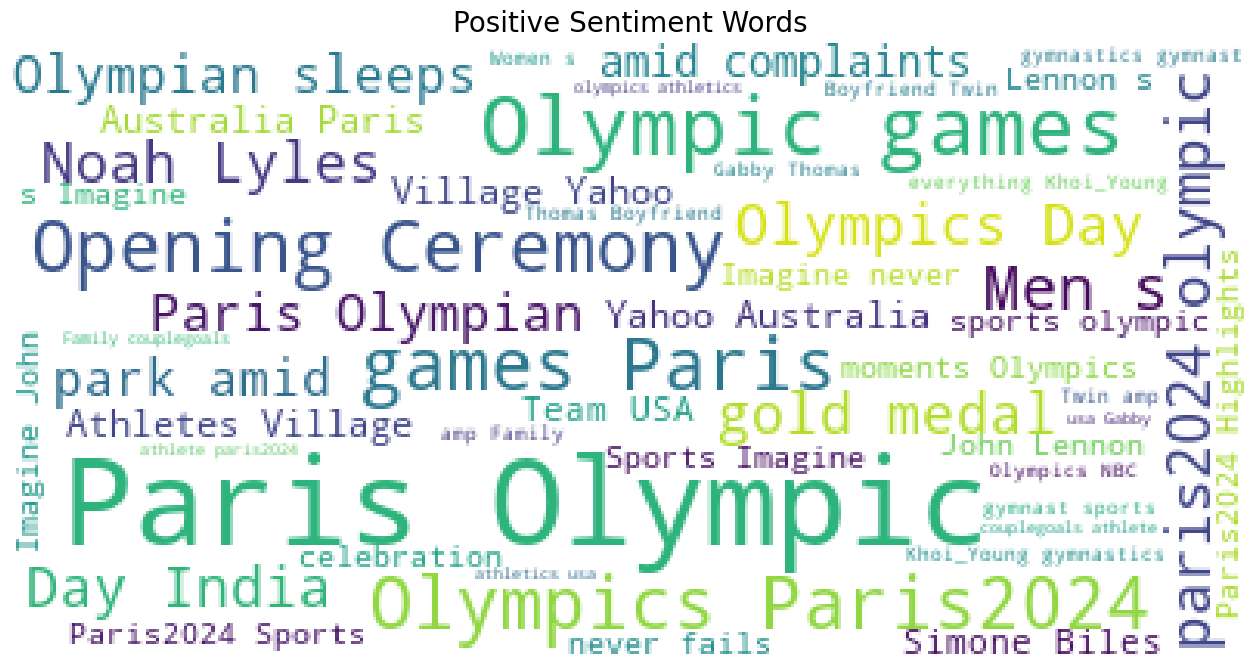

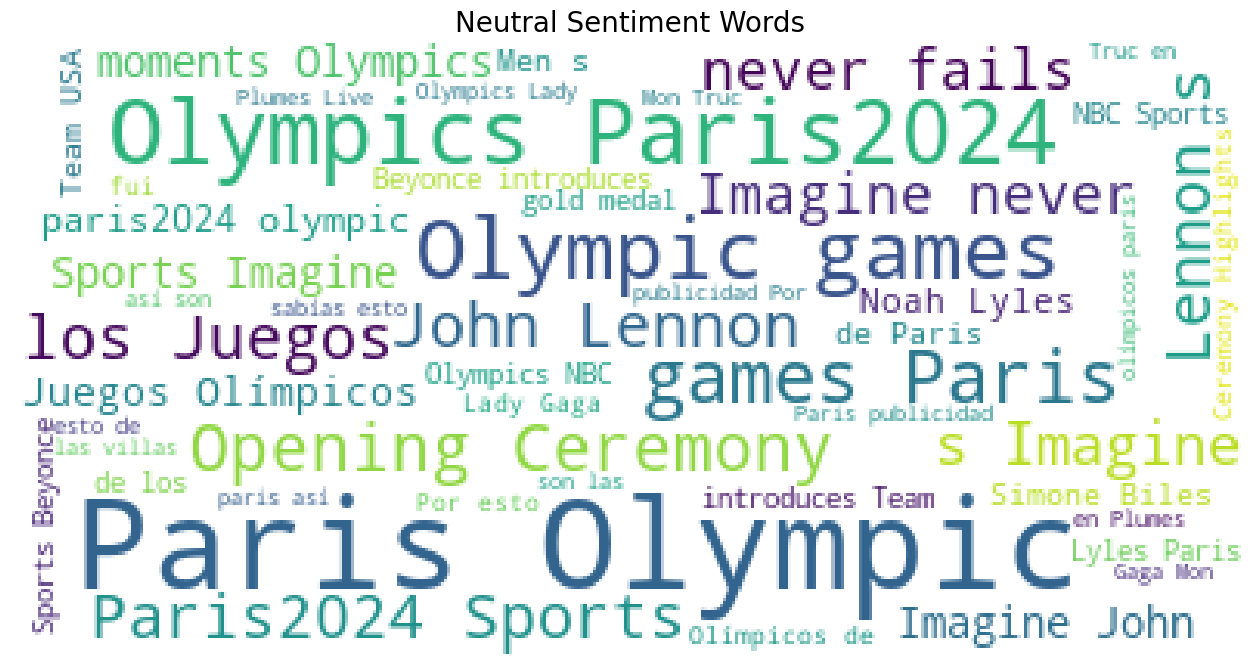

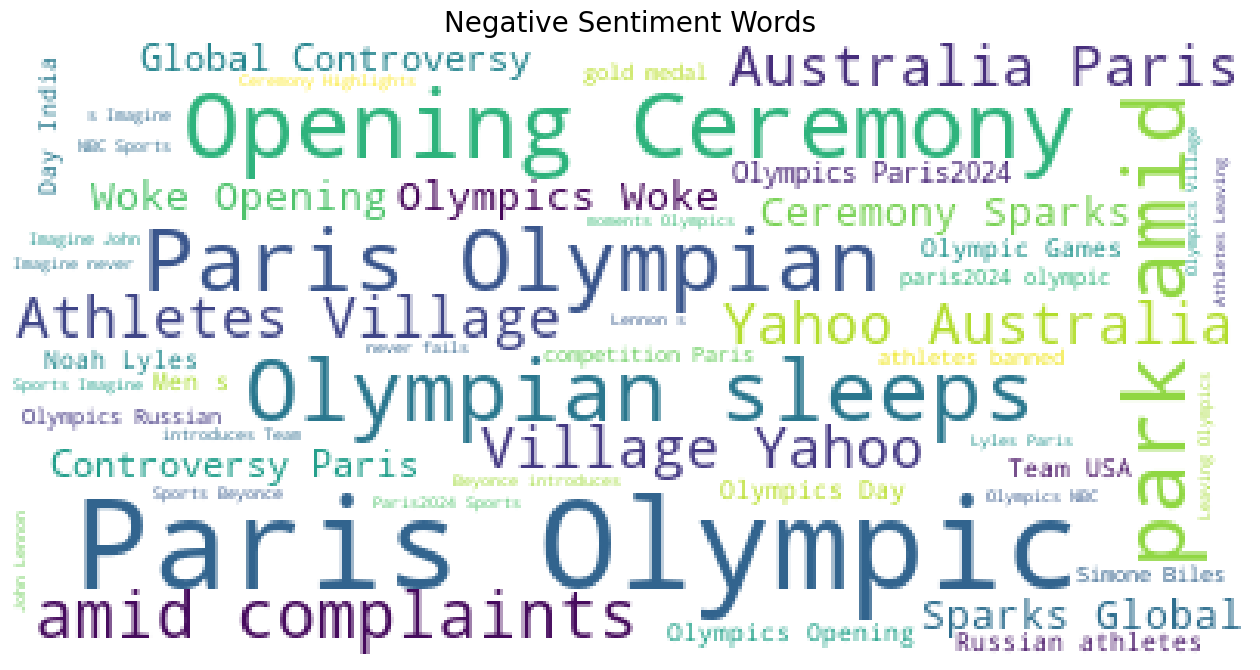

In [19]:
printWordCloud(sentiment_df_2024, 'Positive')
printWordCloud(sentiment_df_2024, 'Neutral')
printWordCloud(sentiment_df_2024, 'Negative')

### Sentiments towards John Lennon in Olympics 2024

In [183]:
# Function to print related text in dataset
def printRelatedText(sentiment_df, text, order):
    sentiment_df['combined text'] = sentiment_df['title'] + ' ' + sentiment_df['text']
    sentiment_df_word = sentiment_df[sentiment_df['combined text'].str.contains(text, case=False, na=False)]
    sentiment_df_word_sorted = sentiment_df_word.reindex(sentiment_df_word['sentiment'].sort_values(ascending=order).index)
    sentiment_df_word_sorted_uniq = sentiment_df_word_sorted.drop_duplicates(subset=['combined text'])
    if order == False:
        # Print the top 3 positive posts 
        print(f"\033[1mTop Positive Post about {text}: {sentiment_df_word_sorted_uniq['title'].iloc[0]}\033[0m \n" + sentiment_df_word_sorted_uniq['text'].iloc[0] + "\n")
        print(f"\033[1mTop 2 Positive Post about {text}: {sentiment_df_word_sorted_uniq['title'].iloc[1]}\033[0m \n" + sentiment_df_word_sorted_uniq['text'].iloc[1] + "\n")
        print(f"\033[1mTop 3 Positive Post about {text}: {sentiment_df_word_sorted_uniq['title'].iloc[2]}\033[0m \n" + sentiment_df_word_sorted_uniq['text'].iloc[2])
    else:
        # Print the top 3 negative posts 
        print(f"\033[1mTop Negative Post about {text}: {sentiment_df_word_sorted_uniq['title'].iloc[0]}\033[0m \n" + sentiment_df_word_sorted_uniq['text'].iloc[0] + "\n")
        print(f"\033[1mTop 2 Negative Post about {text}: {sentiment_df_word_sorted_uniq['title'].iloc[1]}\033[0m \n" + sentiment_df_word_sorted_uniq['text'].iloc[1] + "\n")
        print(f"\033[1mTop 3 Negative Post about {text}: {sentiment_df_word_sorted_uniq['title'].iloc[2]}\033[0m \n" + sentiment_df_word_sorted_uniq['text'].iloc[2])
        

In [156]:
printRelatedText(sentiment_df_2024, 'John Lennon', False)
printRelatedText(sentiment_df_2024, 'John Lennon', True)

Top Positive Post about John Lennon: Full Opening Ceremony ✨| Full Replay | Paris Replays 
ÇA IRA (10:41)

0:10:28 Parade - Victor le Masne (Paris 2024 theme)

ENCHANTÉ (13:21)

0:13:03 La Foule - Édith Piaf
0:14:24 Initials B.B. - Serge Gainsbourg 
0:15:31 La Foule - Édith Piaf
0:18:50 Reality - Vladimir Cosma, Richard Sanderson
0:21:39 Mon truc en plumes - Zizi Jeanmaire (performed by Lady Gaga)
0:26:42 Give Me Love - Cerrone
0:28:20 Chacun Fait (c'qui lui plait) - Chagrin d'amour
0:29:24 Laissez-moi Danser - Dalida
0:30:20 Born To Be alive - Patrick Hernandez
0:30:57 Magnolias For Ever - Claude François
0:32:25 Give Me Love - Cerrone
0:33:10 Chacun Fait (c'qui lui plait) - Chagrin d'amour
0:33:56 Marcia Baïla - Les Rita Mitsouko
0:36:43 Orphée aux Enfers: Galop infernal - Offenbach (Can Can)

SYNCHRONICITÉ (38:24)

0:38:00 Synchronicité - Victor le Masne (Paris 2024 theme)

LIBERTÉ (47:47)

0:47:10 A La Volonté Du Peuple - Les Misérables
0:47:55 Ah! ça ira - Gojira, Marina Viotti
0:

### Sentiments towards Paris Olympics 2024 Wake Opening Ceremony

In [30]:
printRelatedText(sentiment_df_2024, 'Opening Ceremony', False)
printRelatedText(sentiment_df_2024, 'Opening Ceremony', True)

Top Positive Post about Opening Ceremony 
Mrs Amanda,😇❤

President Biden* Passes Torch* VP* (2024)*

VP* Kamala Harris* VP* Pick* (Presidential Campaign)*2024*
(VP)*(Went To Bed)* She Didn't Know
(She Picked Her VP* This Morning)*
VP* Vice President Pick* Gov Tim W.
VP* Govenor* Tim Waltz* (Yes)*(MN)
VP* Served US Representative* 2007
VP* Congressman 2007* To 2019*
VP* Served 2nd Term As Govenor*
VP* He Is A+ Military Veteran*
VP* Govenor Tim Waltz is A Winner*
(WIN)* (LOVE)*(JOY)*(JOHN 3:16)*
VP* Kamala Harris* Secured Votes*
(To Be The Democratic Nominee)*
(Presidential Nomiee)* (2024)*
(August 06, 2024)* (WIN)*

* QueenJoy's Show* (MNBC)*
* Evangeliical Christians* 4 VP* 
*  Republicans 4 Harris*  73,000*
* Union Auto Workers 4 VP* Harris*
* These People Want Brands Back*
* August 14Th, 2024* (WIN)*(2024)*

* VP Kamala Harris* (Presidential)*
* Governor* (MN)* Mr Tim Walz*
* Governor's Wife* Gwen Walz* 
* Govenor' Daughter* (Hope)* (IVF)*
* Govenor's Son* (Gus)* (IVF)*
* (Her VP* Pi

### Olympics 2020

In [34]:
combined_2020 = pd.concat([reddit_2020, reddit_com_2020, youtube_2020, youtube_com_2020], ignore_index=True)
combined_2020.fillna('', inplace=True)

# Apply conversion
combined_2020['created'] = combined_2020['created'].apply(convert_created_date)

# Rename the column name for merging
combined_2020.rename(columns={'created': 'date'}, inplace=True)

# Create a DataFrame for sentiment data
series_2020 = pd.DataFrame(lSentiment_2020, columns=['date', 'keyword', 'sentiment'])

# Merge the two datasets on the date
sentiment_df_2020 = pd.merge(combined_2020, series_2020, on='date', how='left')

# Create a new column using the function above to group the sentiment values
sentiment_df_2020['sentiment_category'] = sentiment_df_2020['sentiment'].apply(categorize_sentiment)


C:\Users\Natalie\AppData\Local\Temp\ipykernel_22680\3451346674.py:1: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  combined_2020 = pd.concat([reddit_2020, reddit_com_2020, youtube_2020, youtube_com_2020], ignore_index=True)


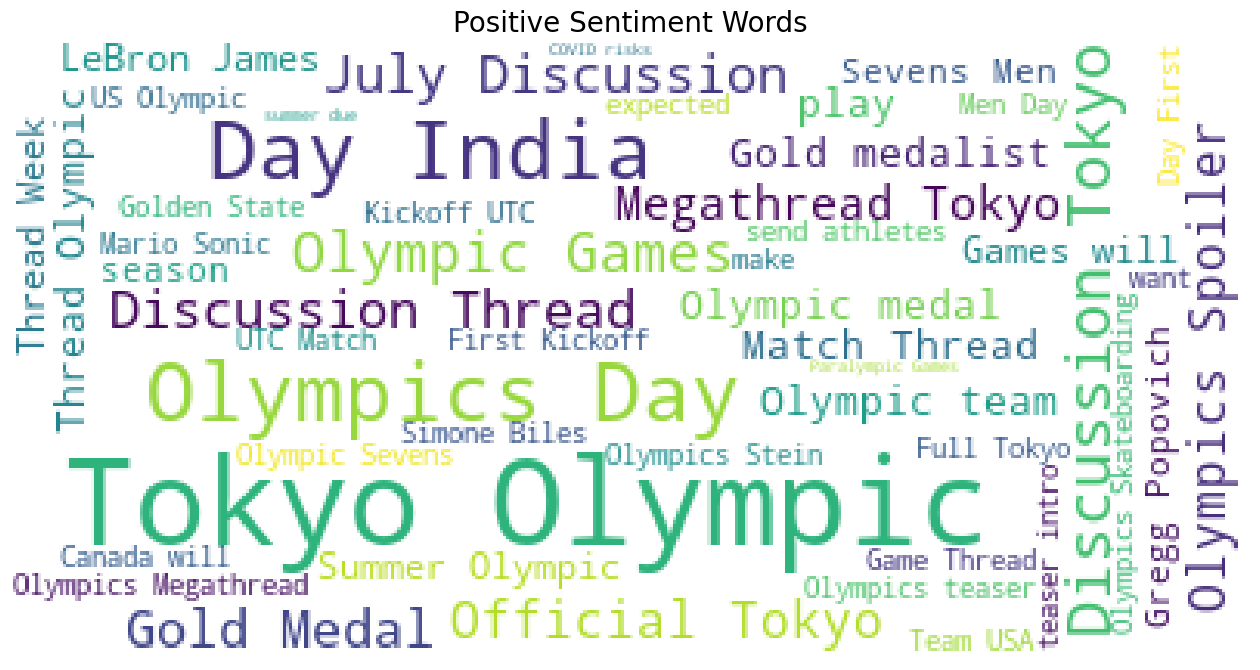

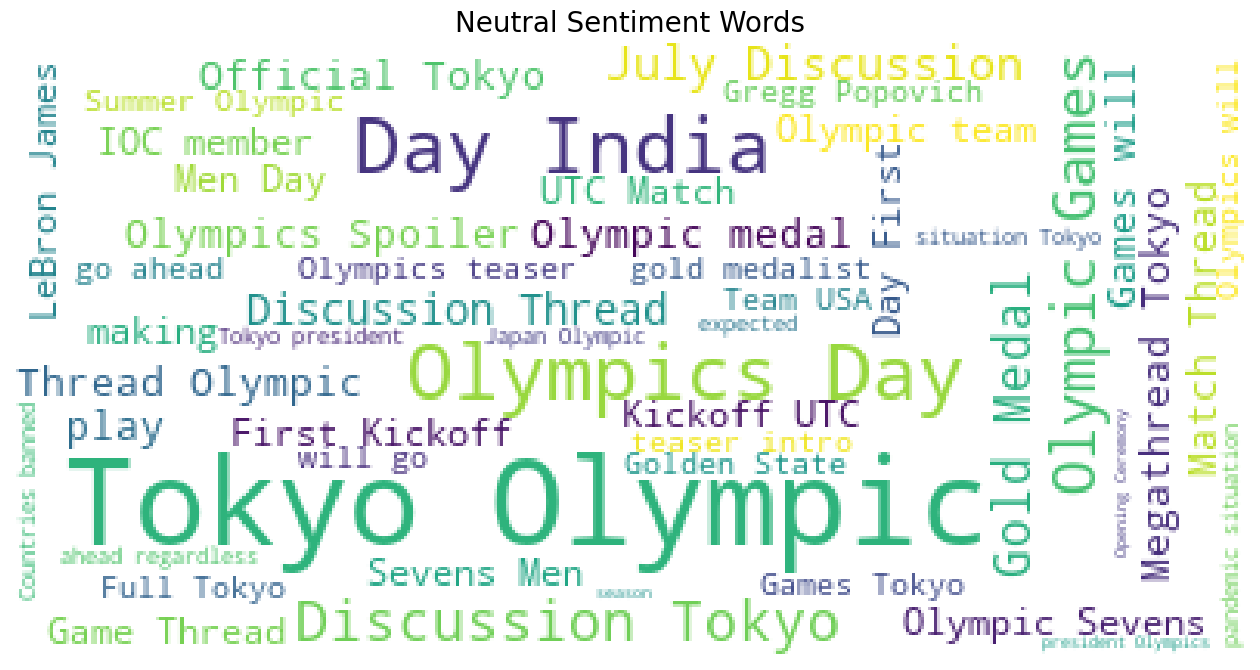

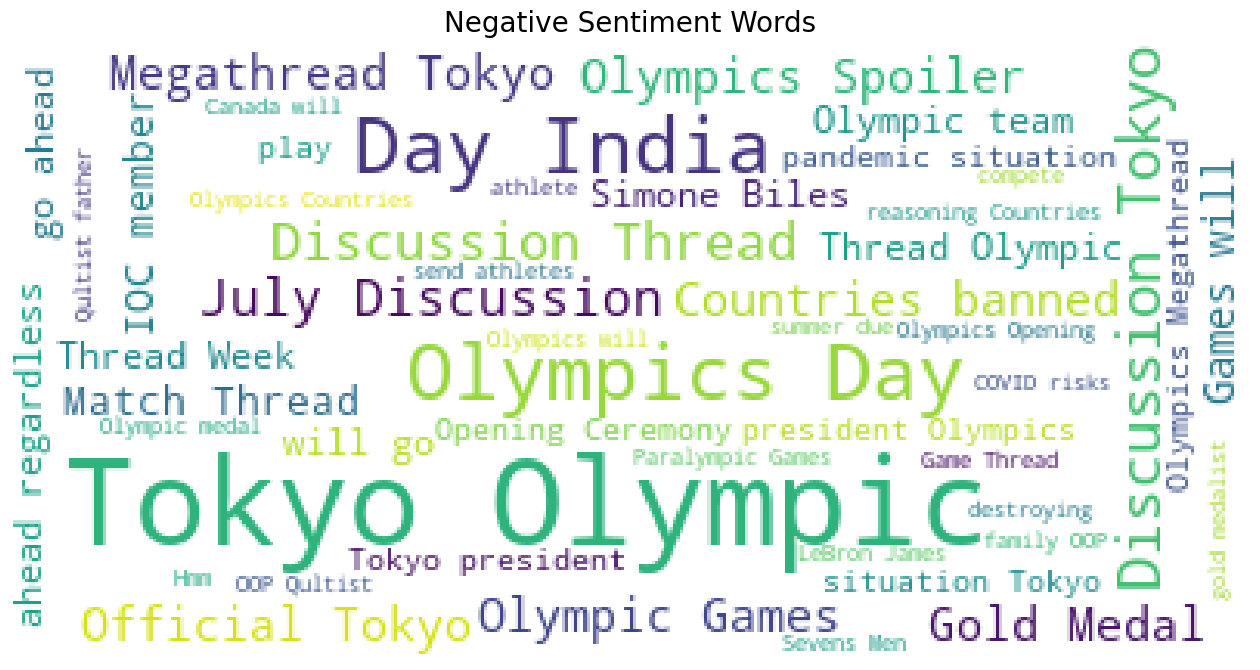

In [35]:
printWordCloud(sentiment_df_2020, 'Positive')
printWordCloud(sentiment_df_2020, 'Neutral')
printWordCloud(sentiment_df_2020, 'Negative')

### Sentiments towards COVID Pandemic

In [163]:
printRelatedText(sentiment_df_2020, r'covid .* risk' , False)

Top Positive Post about covid .* risk: Olympics-Games will go ahead regardless of pandemic situation: Tokyo 2020 president 
It really depends on how old you are and how healthy you are. If you’re under 50 and relatively fit and healthy, you should absolutely not get the vaccine, at least not until the people who really need it get it. And that recommendation of not taking it gets more severe as you get younger. If you’re 21, under no circumstances should you be getting jabbed with a vaccine for a disease that you have negligible risk for. If you’re 45, it should be something you should think about, but I would still strongly discourage it.

The exceptions are people who work with old and vulnerable people — hospice workers, LTC workers, patient-facing hospital workers, EMTs, etc.

Now you could still get the vaccine if you’re 21 and not someone who deals with the old and vulnerable, even if that’s morally  questionable, but there is a group of people who should not be taking the vaccin

In [165]:
printRelatedText(sentiment_df_2020, r'tokyo .* president' , True)

Top Negative Post about tokyo .* president: Olympics-Games will go ahead regardless of pandemic situation: Tokyo 2020 president 
Covid is an excuse for the globalist psychopaths to go full on fascist. We are being controlled, and our human rights denied not because of a medical flu, but because of a political flu. They are intentionally bankrupting independent business and destroying jobs so we'll be desperate and dependent on the govt. Then the govt can dictate terms, like taking that dangerous shot that is damaging and killing people. 

Admins here are their bitches, establishment tools who censor anyone who does not parrot the official lies. Fuck you admins. You can't stop people from speaking the truth. Kiss my ass. Both cheeks.

Top 2 Negative Post about tokyo .* president: Olympics-Games will go ahead regardless of pandemic situation: Tokyo 2020 president 
The pushers of the vaccine are liars. Everything they have rammed down our throats for a year has been one stinking, fetid li

In [167]:
printRelatedText(sentiment_df_2020, r'president .* olympics' , True)

Top Negative Post about president .* olympics: Olympics-Games will go ahead regardless of pandemic situation: Tokyo 2020 president 
I can't really blame Tokyo here. The Olympics has become a damn joke over the years, forcing cities to spend billions on setting up the venue, and enforcing strict advertising and promotional material.

When Tokyo won the bid, work began immediately.

To not host the event now certainly means economical disaster for the city.

Even if the event doesn't draw in the millions, at least some money can be recouped.

&#x200B;

I can't tell you how pleased I am to read many cities are now removing their names from the registry as to not fall into the same financial fiascos as many before it.

Hopefully, this "Olympics" fails, and a new Olympics committee can be formed which focuses on the game, not the money.

Fuck the Olympics. Greedy assholes.

Top 2 Negative Post about president .* olympics: Olympics-Games will go ahead regardless of pandemic situation: Tokyo 

### Sentiments towards LeBron James, Golden State and Gregg Popovich

In [169]:
printRelatedText(sentiment_df_2020, 'LeBron James' , False)
printRelatedText(sentiment_df_2020, 'LeBron James' , True)

Top Positive Post about LeBron James: LeBron James on playing in 2020 Olympics : It would be amazing to play for the greatest NBA coach of all time 
No, but generationally great players really do dictate championships. That's just how the NBA and the game of basketball is. Great players mean more than great coaches. It is fair to say that Phil and Pop were good complimenting coaches for their players, but it is the players who play the game and win or lose. Both Pop and Phil had generationally great players.

Top 2 Positive Post about LeBron James: [Stein] LeBron James tells @joevardon below that he will not play for Team USA at the World Cup in China this summer but says he has not ruled out teaming up with Coach Gregg Popovich for the 2020 Olympics in Tokyo … which would be his fourth Summer Games. 
The list is "Pop."  ...that is pretty much it at this point.  It's not just about winning, but the person himself.  He sees pop as someone who cares about his players, treats his players 

In [171]:
printRelatedText(sentiment_df_2020, 'Golden State' , False)

Top Positive Post about Golden State: [Stein] Draymond Green of the Golden State Warriors told earlier this week that he intended to make himself available for the 2020 Olympics in Japan. Stephen Curry, Green’s Golden State teammate, is also expected to volunteer his services, since Curry has yet to play in an Olympics 
Osaka is awesome dude, there is so much shit to do here. The bar culture is awesome too.  The Dotonbori area (it’s like a river walk type thing) is incredible, it’s basically just a huge maze of cheap restaurants and bars. The public transportation is great too, you can get to pretty much anywhere in Osaka quickly, for cheap, and Apple Maps and Google Maps will both figure out your route for you. The people are super friendly too. I haven’t been to Tokyo, but one of our bartenders, who is an Australian transplant, told me that people are super cold there compared to Osaka. You can pretty much go to any bar here and just meet people (Japanese people and international tou

### Olympics 2016

In [45]:
combined_2016 = pd.concat([reddit_2016, reddit_com_2016, youtube_2016, youtube_com_2016], ignore_index=True)
combined_2016.fillna('', inplace=True)

# Apply conversion
combined_2016['created'] = combined_2016['created'].apply(convert_created_date)

# Rename the column name for merging
combined_2016.rename(columns={'created': 'date'}, inplace=True)

# Create a DataFrame for sentiment data
series_2016 = pd.DataFrame(lSentiment_2016, columns=['date', 'keyword', 'sentiment'])

# Merge the two datasets on the date
sentiment_df_2016 = pd.merge(combined_2016, series_2016, on='date', how='left')

# Create a new column using the function above to group the sentiment values
sentiment_df_2016['sentiment_category'] = sentiment_df_2016['sentiment'].apply(categorize_sentiment)

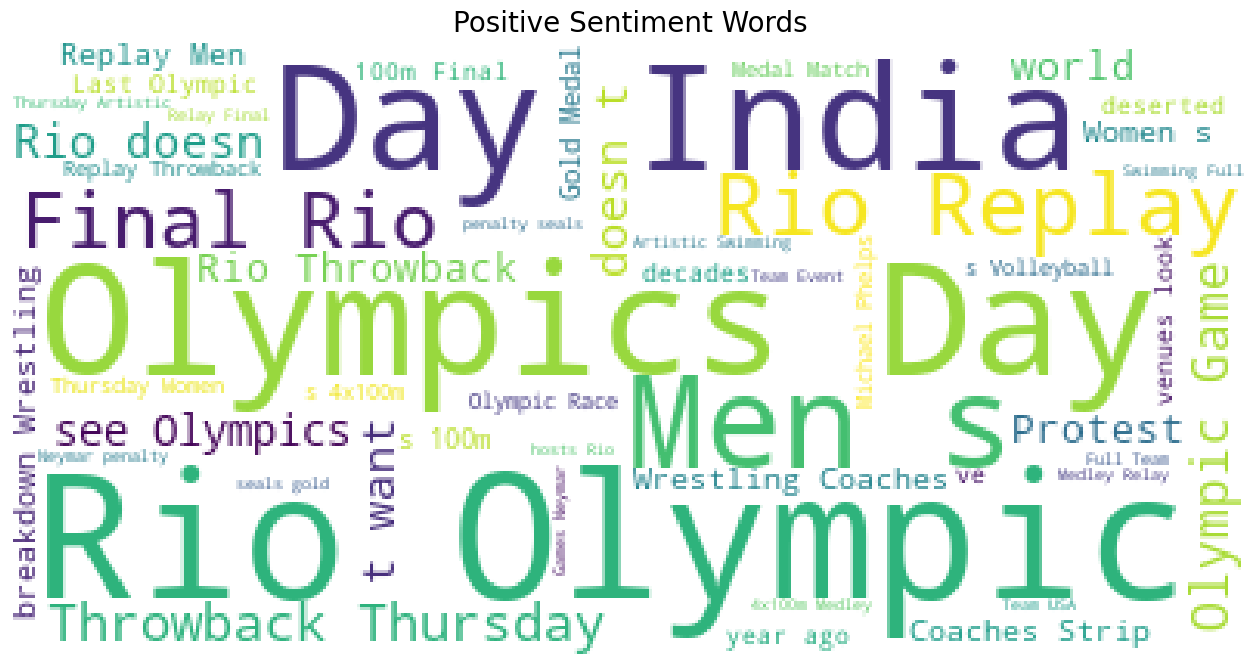

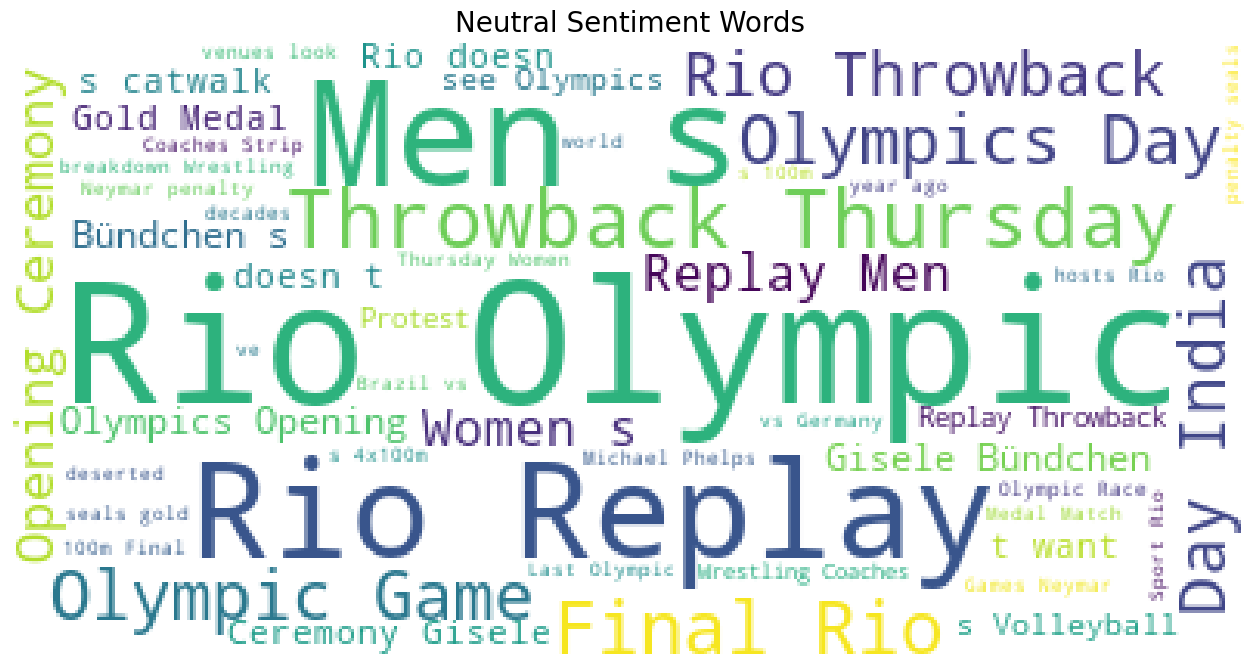

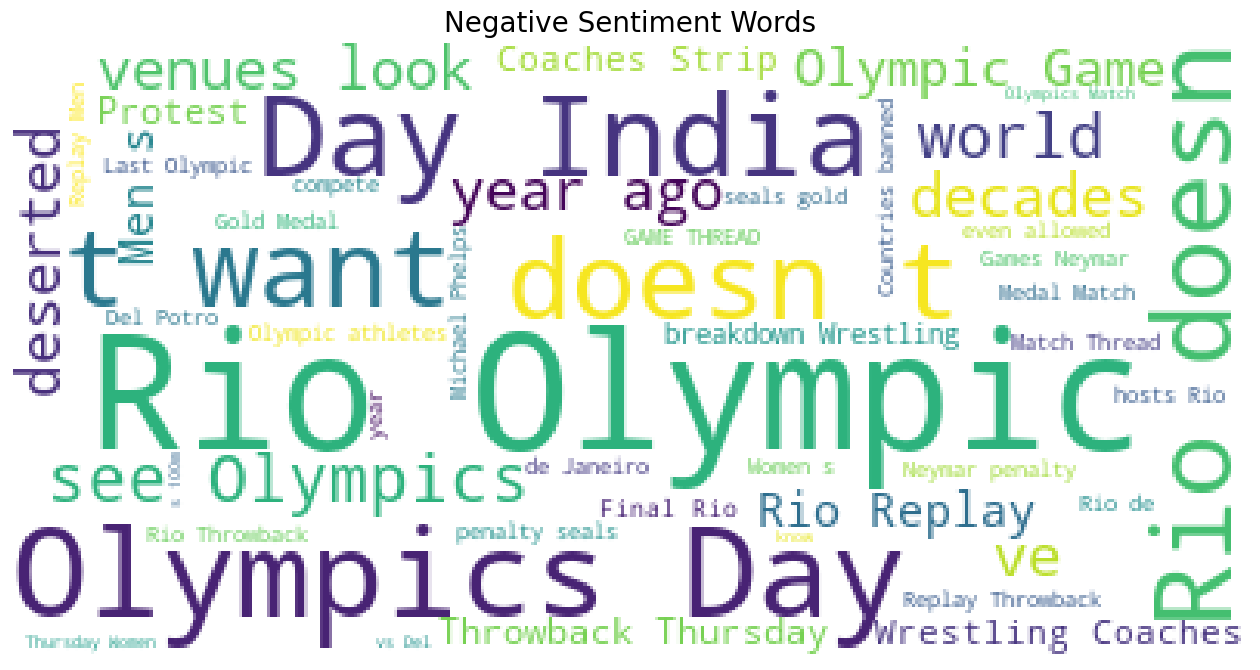

In [46]:
printWordCloud(sentiment_df_2016, 'Positive')
printWordCloud(sentiment_df_2016, 'Neutral')
printWordCloud(sentiment_df_2016, 'Negative')

### Sentiments towards Wrestling

In [174]:
printRelatedText(sentiment_df_2016, 'wrestling coaches' , False)
printRelatedText(sentiment_df_2016, 'wrestling coaches' , True)

Top Positive Post about wrestling coaches: Wrestling Coaches Strip in Protest at the 2016 Olympics, a breakdown 
So when you force your opponents legs to make an arch like a rainbow that is three points. 

This ref. made an error the Uzbekistan in red did a hip over...made an arc with his own legs and counted it as points against the Mongolian in blue. 

*** It is controversial to arch your own legs. You can risk giving points to your opponents and it is the refs discretion to allow it in favor of any competitor or ignore it completely. 

...anyway. The Uzbekistan wrestler did complete a maneuver which placed him on top his Mongolian opponent. This situation is a display of control on a match and SHOULD HAVE BEEN awarded 1 point. Making it 6-5 in favor of blue the Mongolian wrestler. 

In another error the Uzbekistan was celebrating very prematurely. This is called unsportsmanlike conduct.  

Competitors as well as coaches can be penalized in a match for this offense. Points are not ta

### Sentiments towards Neymar da Silva Santos Júnior

In [185]:
printRelatedText(sentiment_df_2016, 'Neymar' , False)
printRelatedText(sentiment_df_2016, 'Neymar' , True)

Top Positive Post about Neymar: Brazil vs Germany - FULL Match - Men&#39;s Football Final Rio 2016 | Throwback Thursday 
That's  a Brazil Force ! we have one of the best football , but we have full respect with Germany , great country , great people , and great football too ! that's moment was epic for we brazilians . Olympic Gold Medal ....so amazing ! and Neymar about crying , a 2 year ago before olympic , he get a injurie and out of world cup in your country , so after goal he kick the obstaclles ! our best footballer in actually . brazlians love germany and full respect .

Top 2 Positive Post about Neymar: Neymar penalty seals gold for hosts | Rio 2016 Olympic Games 
The pride and joy in their eyes and love for their country... It is beautiful to see that passion. Passion only this game can bring you. Brazil is truly the greatest footballing nation in the history. Greetings from Croatia

Top 3 Positive Post about Neymar: Brazil vs Germany - FULL Match - Men&#39;s Football Final Rio